# Meta label metric

Testing different meta label metric

- precision
- recall
- f1-score
- auc
- kappa

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import evaluator, MetaEvaluator

## Macros

In [2]:
BASE_MODEL = "RandomForestClassifier"
META_MODEL = "LGBMRegressor"
DATASET = "electricity"
META_LABELS = list(evaluator.clf_metrics)

MTL_COL = "predicted"
BASELINE_COL_SUFFIX = "last_"
ETA = 50
STEP = 5

## Read data

In [3]:
dfs = {}

for meta_label in META_LABELS:
    filename = f"metabases/metamodel: {META_MODEL} - basemodel: {BASE_MODEL} - metric: {meta_label} - dataset: {DATASET}.csv"
    dfs[meta_label] = pd.read_csv(filename).dropna()

# Results

In [4]:
meta_evals = {}

for meta_label in META_LABELS:
    meta_evals[meta_label] =  MetaEvaluator(
        baseline_col = f"{BASELINE_COL_SUFFIX}{meta_label}",
        mtl_col = MTL_COL,
        target_col = meta_label,
        eta = ETA,
        step = STEP
    ).fit(dfs[meta_label])

Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)


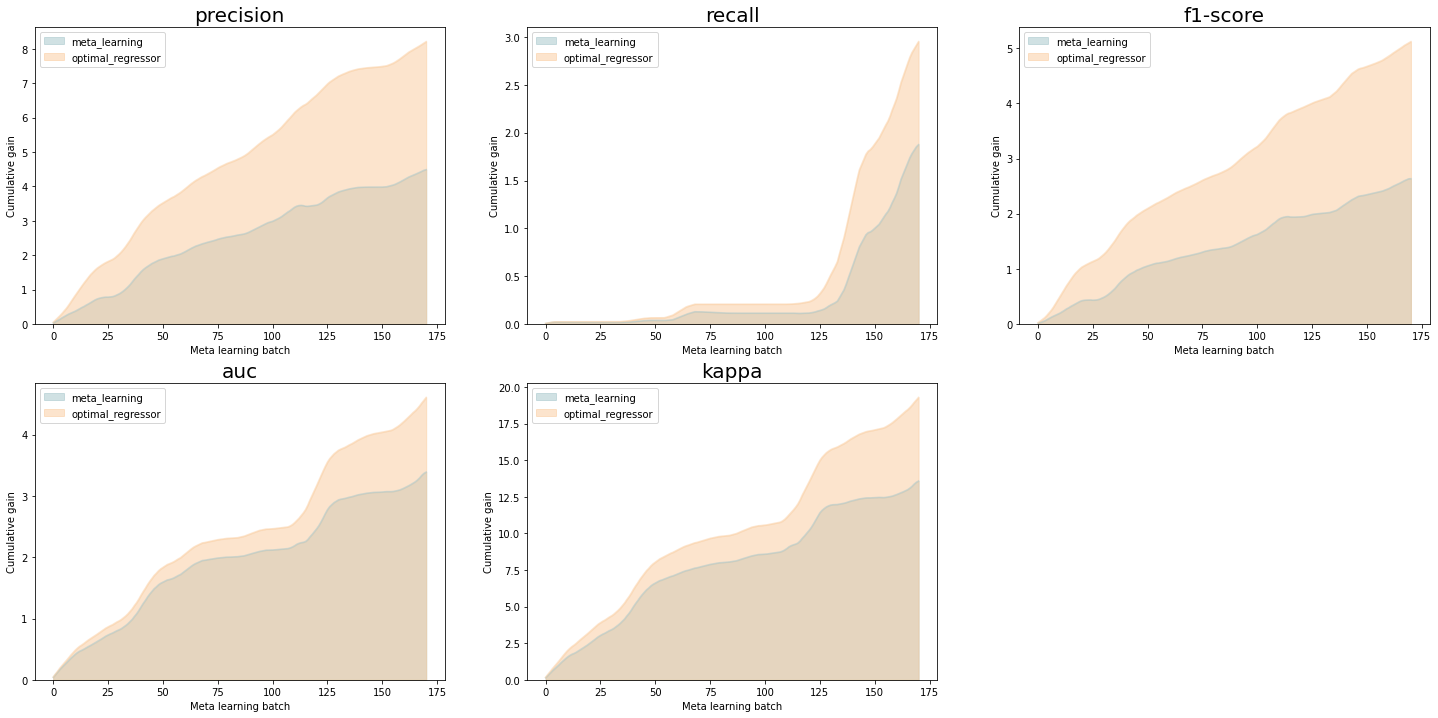

In [5]:
plt.figure(figsize=(25, 12))

for idx, meta_label in enumerate(META_LABELS):
    meta_evals[meta_label].plot_cumulative_gain(meta_label, subplot_tuple=(2, 3, idx + 1))

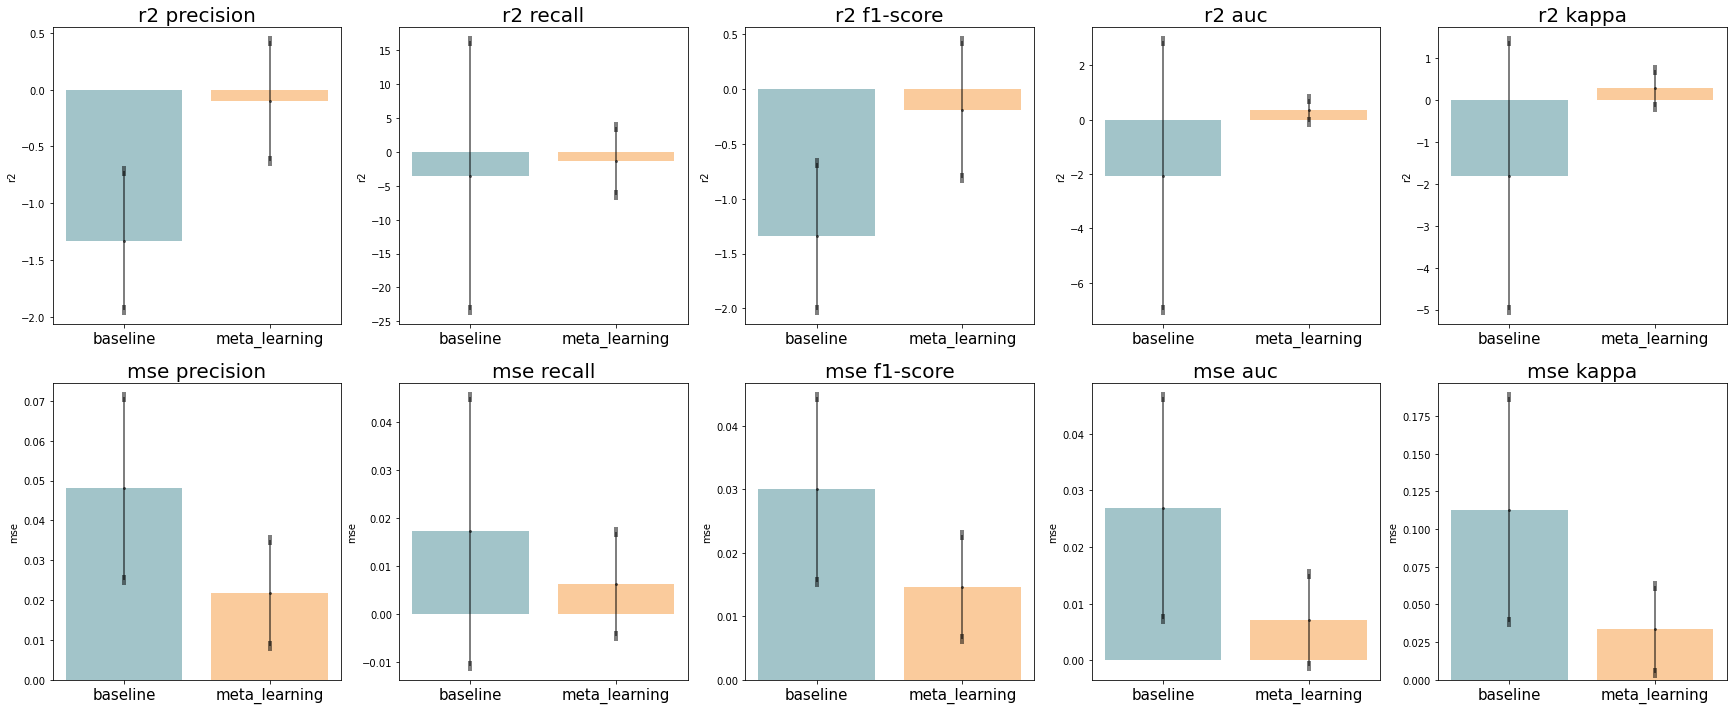

In [6]:
plt.figure(figsize=(30, 12))
plt.rc('xtick',labelsize=15)
for idx, meta_labels in enumerate(META_LABELS):
    plt.subplot(2, 5, idx+1)
    meta_evals[meta_labels].barchart_with_std("r2", meta_labels)
    plt.subplot(2, 5, idx+len(META_LABELS)+1)
    meta_evals[meta_labels].barchart_with_std("mse", meta_labels)